Objective : 
The objective of this analysis is to build a image classification deep learning model for a small data set of 10 different type of model using multiple per trained models as a base and then comparing there performance to a benchmark model that is a normal Covnet trained from scratch on the same dataset    
Plan: 
 First the data augmentation will be used to increase the size of the training set then the images will be scaled to small enough size for the networks to work on. Them a medium size covnet will be trained and evaluated to set the benchmark for the  pre-trained model the these models will be trained and evaluated and the best performing one will be selected for further improvement. 


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import random
import os
import cv2
from IPython.display import Image
import matplotlib.pyplot as plt
import seaborn as sns

from keras.utils import plot_model
from sklearn.metrics import classification_report
from collections import Counter
import tensorflow as tf

import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.vgg16 import VGG16

from keras import Model, layers
from keras.models import Sequential
from keras.optimizers import Adam, SGD
from keras.layers import GlobalMaxPooling2D, GlobalAveragePooling2D, Dropout, Dense, Input, Conv2D, MaxPooling2D, Flatten,MaxPooling3D

Dataset : 
The data set was downloaded form Kaggle website and  consists of This dataset can be used to do multiclass image classification.. It contains 10 folders each contains 40 -60 images  for the training folder and 10-20 in the test set and the classes are :bike ,boat ,bus ,car ,cycle ,helicopter ,plane ,scooty ,train , 

In [3]:
import numpy as np
import matplotlib.image as mpimg
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

path='data\\vechicle_with_train\\vechicles\\train'
im=ImageDataGenerator(
        rescale=1 / 255.0,
        rotation_range=40,
        zoom_range=0.3,
        width_shift_range=0.3,
        height_shift_range=0.3,
        shear_range=0.3,
        horizontal_flip=True,


        )
train_generator = im.flow_from_directory(path,
    target_size=(150, 150),
    color_mode="rgb",
    batch_size=33,
    class_mode="categorical",
    subset='training',
    shuffle=True,
)

Found 526 images belonging to 10 classes.


In [4]:

# epoch config
benchmark_epoch = 100
vgg_epoch = 100
resnet_epoch = 100
inception_epoch =100

data exploration and cleaning :  
  
The data for the training was processed through and image data generator that rescales the image and produce a random rotation , zoom, height and width shift ,shear and horizontal flip , and the produced image is rescaled to 150*150 p  
The training set was then split into a training and validation set  


Number of images in the train set :  526
Number of images in the test set ;  74


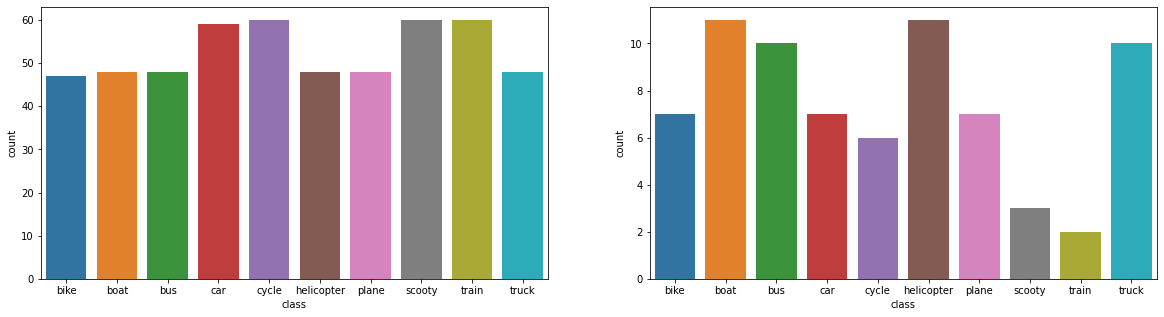

In [5]:


root_path = 'data\\vechicle_with_train\\vechicles\\'
train_pred_test_folders = os.listdir(root_path)

seg_train_folders = 'data\\vechicle_with_train\\vechicles\\train\\' #one more seg_train folder within
seg_test_folders = 'data\\vechicle_with_train\\vechicles\\test\\'
#seg_pred_folders = '../input/intel-image-classification/seg_pred/seg_pred/'
quantity_tr = {} 
quantity_te = {}
for folder in os.listdir(seg_train_folders):
    quantity_tr[folder] = len(os.listdir(seg_train_folders+folder))

for folder in os.listdir(seg_test_folders):
    quantity_te[folder] = len(os.listdir(seg_test_folders+folder))
    
quantity_train = pd.DataFrame(list(quantity_tr.items()), index=range(0,len(quantity_tr)), columns=['class','count'])
quantity_test = pd.DataFrame(list(quantity_te.items()), index=range(0,len(quantity_te)), columns=['class','count'])

figure, ax = plt.subplots(1,2,figsize=(20,5))
sns.barplot(x='class',y='count',data=quantity_train,ax=ax[0])
sns.barplot(x='class',y='count',data=quantity_test,ax=ax[1])

print("Number of images in the train set : ", sum(quantity_tr.values()))
print("Number of images in the test set ; ",sum(quantity_te.values()))

plt.show()

In [6]:
def save_history(history, model_name):
    #convert the history.history dict to a pandas DataFrame:     
    hist_df = pd.DataFrame(history.history) 

    # save to json:  
    hist_json_file = model_name+'_history.json' 
    with open(hist_json_file, mode='w') as f:
        hist_df.to_json(f)

    # or save to csv: 
    hist_csv_file = model_name+'_history.csv'
    with open(hist_csv_file, mode='w') as f:
        hist_df.to_csv(f)
        
def plot_accuracy_from_history(history, isinception=False):
    color = sns.color_palette()
    if(isinception == False):
        acc = history.history['acc']
        val_acc = history.history['val_acc']
    else:
        acc = history.history['accuracy']
        val_acc = history.history['val_accuracy']
    

    epochs = range(len(acc))

    sns.lineplot(epochs, acc, label='Training Accuracy')
    sns.lineplot(epochs, val_acc,label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.figure()
    plt.show()
    
def plot_loss_from_history(history):
    color = sns.color_palette()
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs = range(len(loss))
    
    sns.lineplot(epochs, loss,label='Training Loss')
    sns.lineplot(epochs, val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.figure()
    plt.show()
    
def do_history_stuff(history, history_file_name, isinception=False):
    save_history(history, history_file_name)
    plot_accuracy_from_history(history, isinception)
    plot_loss_from_history(history)

In [ ]:
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt 
from sklearn.metrics import classification_report
#from mlxtend.plotting import plot_confusion_matrix
def clf_report(true_value, model_pred):
    
    classes = train_generator.class_indices.keys()
    TP_count = [true_value[i] == model_pred[i] for i in range(len(true_value))]
    model_accuracy = np.sum(TP_count)/len(TP_count)
    print('Model Accuracy', model_accuracy)
    
    plt.figure(figsize=(7,7))
    cm = confusion_matrix(true_value,model_pred)
    plt.imshow(cm,interpolation='nearest',cmap=plt.cm.viridis)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    thresh = cm.max()*0.8
    for i,j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
        plt.text(j,i,cm[i,j],
                horizontalalignment="center",
                color="red" if cm[i,j] > thresh else "white")
        pass
    
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    pass
    
    print(classification_report(true_value, model_pred, target_names = list(classes)))
    

In [7]:
path2='data\\vechicle_with_train\\vechicles\\test'
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
       path2,
        target_size=(150, 150),
        batch_size=32,
        class_mode='categorical')
val_datagen = ImageDataGenerator(rescale=1./255)
val_generator = test_datagen.flow_from_directory(
       path2,
        target_size=(150, 150),
        batch_size=32,
        class_mode='categorical')



Found 74 images belonging to 10 classes.
Found 74 images belonging to 10 classes.


In [8]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  1


Training summary: 
The training data was produced by an ImageDataGenerator function and was feed to the neural networks . 
The number of training epochs is decided to be 100 or until no improvement is noticed in 5 epochs  and the batch size is 32 images . 
With optimizer='adam' and  loss='categorical_crossentropy' 
All the models were trained to improve validation accrucay  


Benchmark model :a convolutional neural network was trained form scratch  with the flowing Code 

In [ ]:
benchmark_model = Sequential()
# Input here is 4D array (batchsize, height, width, channels) - we have already created the train_generator with batch size 32
# 32 Images of size each 150x150 with 3 color channels will be input into this layer
benchmark_model.add(Conv2D(128, kernel_size=7, activation='relu', input_shape=(150,150,3)))
benchmark_model.add(MaxPooling2D(pool_size=(4,4), strides=(2,2)))
benchmark_model.add(Conv2D(64, kernel_size=5, activation='relu'))
benchmark_model.add(MaxPooling2D(pool_size=(4,4), strides=(2,2)))
benchmark_model.add(Flatten())
benchmark_model.add(Dense(128,activation='relu'))
benchmark_model.add(Dense(10,activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

model.summary()

In [10]:
filepath = "bench//bench_mark_-model-{epoch:02d}-{val_acc:.2f}.hdf5"
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.05, patience=5, min_lr=0.000002)
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=20)
history = model.fit(train_generator,epochs=benchmark_epoch, verbose=1, validation_data = val_generator,callbacks=[reduce_lr,early_stopping,checkpoint])


do_history_stuff(history, 'benchmark_model')

In [9]:
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt 
from sklearn.metrics import classification_report
#from mlxtend.plotting import plot_confusion_matrix
def clf_report(true_value, model_pred):
    
    classes = train_generator.class_indices.keys()
    TP_count = [true_value[i] == model_pred[i] for i in range(len(true_value))]
    model_accuracy = np.sum(TP_count)/len(TP_count)
    print('Model Accuracy', model_accuracy)
    
    plt.figure(figsize=(7,7))
    cm = confusion_matrix(true_value,model_pred)
    plt.imshow(cm,interpolation='nearest',cmap=plt.cm.viridis)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    thresh = cm.max()*0.8
    for i,j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
        plt.text(j,i,cm[i,j],
                horizontalalignment="center",
                color="red" if cm[i,j] > thresh else "white")
        pass
    
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    pass
    
    print(classification_report(true_value, model_pred, target_names = list(classes)))
    

Model Accuracy 0.28378378378378377


c:\users\hp\pycharmprojects\pythonproject5\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\hp\pycharmprojects\pythonproject5\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\hp\pycharmprojects\pythonproject5\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

        bike       0.32      0.86      0.46         7
        boat       0.29      0.18      0.22        11
         bus       0.45      0.50      0.48        10
         car       0.00      0.00      0.00         7
       cycle       0.55      1.00      0.71         6
  helicopter       0.00      0.00      0.00        11
       plane       0.00      0.00      0.00         7
      scooty       0.11      0.67      0.18         3
       train       0.00      0.00      0.00         2
       truck       0.00      0.00      0.00        10

    accuracy                           0.28        74
   macro avg       0.17      0.32      0.20        74
weighted avg       0.18      0.28      0.21        74



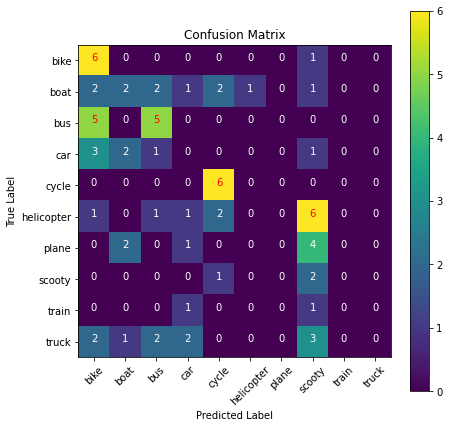

In [31]:
clf_report(true_value, benchmark_model_pred)

Vgg16 : 
A vgg16 with imagnet weights was downloaded without the top layers and set to not trainable and then  
A Flatten layer and  Dense(128, activation = 'relu') layer  and Dense (10, activation = 'softmax') were added on the top of the model  categorical_crossentropy loss and adam optimizer were used for the compiling . 


Epoch 1/100
16/16 [==============================] - ETA: 0s - loss: 2.2444 - acc: 0.1629
Epoch 1: val_acc improved from -inf to 0.22973, saving model to vgg_16_-saved-model-01-acc-0.23.hdf5
16/16 [==============================] - 25s 1s/step - loss: 2.2444 - acc: 0.1629 - val_loss: 2.1267 - val_acc: 0.2297
Epoch 2/100
16/16 [==============================] - ETA: 0s - loss: 1.9526 - acc: 0.3561
Epoch 2: val_acc improved from 0.22973 to 0.43243, saving model to vgg_16_-saved-model-02-acc-0.43.hdf5
16/16 [==============================] - 14s 877ms/step - loss: 1.9526 - acc: 0.3561 - val_loss: 1.8099 - val_acc: 0.4324
Epoch 3/100
16/16 [==============================] - ETA: 0s - loss: 1.7079 - acc: 0.5114
Epoch 3: val_acc improved from 0.43243 to 0.50000, saving model to vgg_16_-saved-model-03-acc-0.50.hdf5
16/16 [==============================] - 14s 882ms/step - loss: 1.7079 - acc: 0.5114 - val_loss: 1.6297 - val_acc: 0.5000
Epoch 4/100
16/16 [==============================] - ETA: 

Epoch 30/100
16/16 [==============================] - ETA: 0s - loss: 0.6984 - acc: 0.7727
Epoch 30: val_acc did not improve from 0.75676
16/16 [==============================] - 14s 873ms/step - loss: 0.6984 - acc: 0.7727 - val_loss: 0.9048 - val_acc: 0.7027
Epoch 31/100
16/16 [==============================] - ETA: 0s - loss: 0.6876 - acc: 0.7784
Epoch 31: val_acc did not improve from 0.75676
16/16 [==============================] - 14s 850ms/step - loss: 0.6876 - acc: 0.7784 - val_loss: 0.8807 - val_acc: 0.6892
Epoch 32/100
16/16 [==============================] - ETA: 0s - loss: 0.6715 - acc: 0.7670
Epoch 32: val_acc did not improve from 0.75676
16/16 [==============================] - 14s 885ms/step - loss: 0.6715 - acc: 0.7670 - val_loss: 0.8734 - val_acc: 0.7162
Epoch 33/100
16/16 [==============================] - ETA: 0s - loss: 0.6921 - acc: 0.7633
Epoch 33: val_acc did not improve from 0.75676
16/16 [==============================] - 14s 870ms/step - loss: 0.6921 - acc: 0.76

c:\users\hp\pycharmprojects\pythonproject5\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
c:\users\hp\pycharmprojects\pythonproject5\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


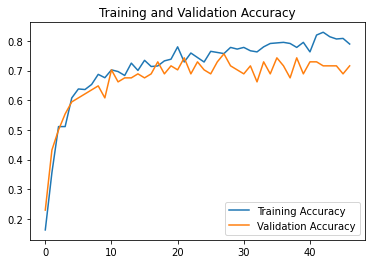

<Figure size 432x288 with 0 Axes>

c:\users\hp\pycharmprojects\pythonproject5\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
c:\users\hp\pycharmprojects\pythonproject5\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


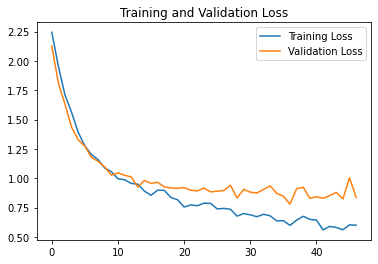

<Figure size 432x288 with 0 Axes>

In [14]:
vgg16_model = VGG16(pooling='avg', weights='imagenet', include_top=False, input_shape=(150,150,3))
for layers in vgg16_model.layers:
            layers.trainable=False
last_output = vgg16_model.layers[-1].output
vgg_x = Flatten()(last_output)
vgg_x = Dense(128, activation = 'relu')(vgg_x)
vgg_x = Dense(10, activation = 'softmax')(vgg_x)
vgg16_final_model = Model(vgg16_model.input, vgg_x)
vgg16_final_model.compile(loss = 'categorical_crossentropy', optimizer= 'adam', metrics=['acc'])

# VGG16
number_of_epochs = 100
vgg16_filepath = 'vgg_16_'+'-saved-model-{epoch:02d}-acc-{val_acc:.2f}.hdf5'
vgg_checkpoint = tf.keras.callbacks.ModelCheckpoint(vgg16_filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
vgg_early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
vgg16_history = vgg16_final_model.fit(train_generator, epochs = number_of_epochs ,validation_data = val_generator,callbacks=[vgg_checkpoint,vgg_early_stopping],verbose=1)

do_history_stuff(vgg16_history, 'vgg16_model')

In [ ]:
clf_report(true_value, vgg_pred
          )

In [4]:
import torch
use_cuda = torch.cuda.is_available()

if use_cuda:
    print('__CUDNN VERSION:', torch.backends.cudnn.version())
    print('__Number CUDA Devices:', torch.cuda.device_count())
    print('__CUDA Device Name:',torch.cuda.get_device_name(0))
    print('__CUDA Device Total Memory [GB]:',torch.cuda.get_device_properties(0).total_memory/1e9)


In [5]:
torch.cuda.is_available()

False

In [ ]:
import GPUtil
GPUtil.getAvailable()

In [ ]:
print('__CUDNN VERSION:', torch.backends.cudnn.version())
print('__Number CUDA Devices:', torch.cuda.device_count())
print('__CUDA Device Name:',torch.cuda.get_device_name(0))
print('__CUDA Device Total Memory [GB]:',torch.cuda.get_device_properties(0).total_memory/1e9)

In [60]:
benchmark_model = Sequential()
# Input here is 4D array (batchsize, height, width, channels) - we have already created the train_generator with batch size 32
# 32 Images of size each 150x150 with 3 color channels will be input into this layer
benchmark_model.add(Conv2D(128, kernel_size=7, activation='relu', input_shape=(150,150,3)))
benchmark_model.add(MaxPooling2D(pool_size=(4,4), strides=(2,2)))
benchmark_model.add(Conv2D(64, kernel_size=5, activation='relu'))
benchmark_model.add(MaxPooling2D(pool_size=(4,4), strides=(2,2)))
benchmark_model.add(Flatten())
benchmark_model.add(Dense(128,activation='relu'))
benchmark_model.add(Dense(10,activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_267 (Conv2D)         (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d_79 (MaxPoolin  (None, 74, 74, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_268 (Conv2D)         (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_80 (MaxPoolin  (None, 36, 36, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_269 (Conv2D)         (None, 34, 34, 64)        18496     
                                                                 
 max_pooling2d_81 (MaxPoolin  (None, 17, 17, 64)     

Epoch 1/100
16/16 [==============================] - ETA: 0s - loss: 2.3042 - acc: 0.1042
Epoch 1: val_acc improved from -inf to 0.08108, saving model to bench\bench_mark_-model-01-0.08.hdf5
16/16 [==============================] - 7s 344ms/step - loss: 2.3042 - acc: 0.1042 - val_loss: 2.3518 - val_acc: 0.0811 - lr: 0.0010
Epoch 2/100
16/16 [==============================] - ETA: 0s - loss: 2.2808 - acc: 0.1080
Epoch 2: val_acc did not improve from 0.08108
16/16 [==============================] - 5s 288ms/step - loss: 2.2808 - acc: 0.1080 - val_loss: 2.4992 - val_acc: 0.0811 - lr: 0.0010
Epoch 3/100
16/16 [==============================] - ETA: 0s - loss: 2.2526 - acc: 0.1326
Epoch 3: val_acc did not improve from 0.08108
16/16 [==============================] - 5s 316ms/step - loss: 2.2526 - acc: 0.1326 - val_loss: 2.2645 - val_acc: 0.0811 - lr: 0.0010
Epoch 4/100
16/16 [==============================] - ETA: 0s - loss: 2.2602 - acc: 0.1326
Epoch 4: val_acc improved from 0.08108 to 0.1

Epoch 30/100
16/16 [==============================] - ETA: 0s - loss: 1.9753 - acc: 0.2633
Epoch 30: val_acc did not improve from 0.22973
16/16 [==============================] - 5s 293ms/step - loss: 1.9753 - acc: 0.2633 - val_loss: 2.1406 - val_acc: 0.2162 - lr: 2.0000e-06
Epoch 31/100
16/16 [==============================] - ETA: 0s - loss: 1.9785 - acc: 0.2405
Epoch 31: val_acc did not improve from 0.22973
16/16 [==============================] - 5s 307ms/step - loss: 1.9785 - acc: 0.2405 - val_loss: 2.1403 - val_acc: 0.2162 - lr: 2.0000e-06
Epoch 32/100
16/16 [==============================] - ETA: 0s - loss: 1.9680 - acc: 0.2576
Epoch 32: val_acc did not improve from 0.22973
16/16 [==============================] - 5s 290ms/step - loss: 1.9680 - acc: 0.2576 - val_loss: 2.1383 - val_acc: 0.2162 - lr: 2.0000e-06
Epoch 33/100
16/16 [==============================] - ETA: 0s - loss: 1.9763 - acc: 0.2652
Epoch 33: val_acc did not improve from 0.22973
16/16 [===========================

c:\users\hp\pycharmprojects\pythonproject5\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
c:\users\hp\pycharmprojects\pythonproject5\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


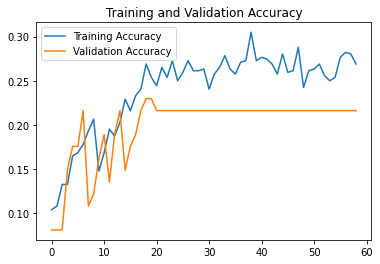

<Figure size 432x288 with 0 Axes>

c:\users\hp\pycharmprojects\pythonproject5\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
c:\users\hp\pycharmprojects\pythonproject5\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


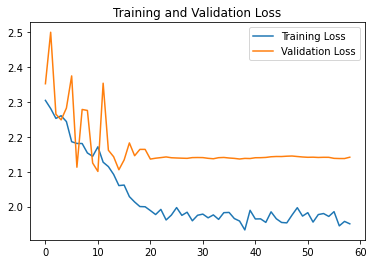

<Figure size 432x288 with 0 Axes>

In [68]:
filepath = "bench//bench_mark_-model-{epoch:02d}-{val_acc:.2f}.hdf5"
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.05, patience=5, min_lr=0.000002)
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=20)
history = model.fit(train_generator,epochs=benchmark_epoch, verbose=1, validation_data = val_generator,callbacks=[reduce_lr,early_stopping,checkpoint])


do_history_stuff(history, 'benchmark_model')

Resnet model: 
A resnet50 with imagnet weights was downloaded without the top layers and set to not trainable and then  
A Flatten layer and  Dense(256, activation = 'relu') layer  and Dense (10, activation = 'softmax') were added on the top of the model  categorical_crossentropy loss and SGD  optimizer were used for the compiling . 


In [15]:


ResNet50_model = ResNet50(weights='imagenet', include_top=False, input_shape=(150,150,3), classes=10)

for layers in ResNet50_model.layers:
    layers.trainable=True

opt = SGD(lr=0.01,momentum=0.7)
#resnet50_x = Conv2D(64, (3, 3), activation='relu')(ResNet50_model.output)
#resnet50_x = MaxPooling2D(pool_size=(3, 3))(resnet50_x)
resnet50_x = Flatten()(ResNet50_model.output)
resnet50_x = Dense(256,activation='relu')(resnet50_x)
resnet50_x = Dense(10,activation='softmax')(resnet50_x)
resnet50_x_final_model = Model(inputs=ResNet50_model.input, outputs=resnet50_x)
resnet50_x_final_model.compile(loss = 'categorical_crossentropy', optimizer= opt, metrics=['acc'])

number_of_epochs = resnet_epoch
resnet_filepath = 'resnet50'+'-saved-model-{epoch:02d}-val_acc-{val_acc:.2f}.hdf5'
resnet_checkpoint = tf.keras.callbacks.ModelCheckpoint(resnet_filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
resnet_early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.05, patience=5, min_lr=0.000002)
callbacklist = [resnet_checkpoint,resnet_early_stopping,reduce_lr]
resnet50_history = resnet50_x_final_model.fit(train_generator, epochs = number_of_epochs ,validation_data = val_generator,callbacks=callbacklist,verbose=1)

do_history_stuff(resnet50_history, 'resnet50_model')



Epoch 1/100
 1/16 [>.............................] - ETA: 2:56 - loss: 3.6387 - acc: 0.0606

ResourceExhaustedError: Graph execution error:

Detected at node 'gradient_tape/model_2/dense_7/MatMul/MatMul_1' defined at (most recent call last):
    File "C:\Users\hp\AppData\Local\Programs\Python\Python37\lib\runpy.py", line 193, in _run_module_as_main
      "__main__", mod_spec)
    File "C:\Users\hp\AppData\Local\Programs\Python\Python37\lib\runpy.py", line 85, in _run_code
      exec(code, run_globals)
    File "c:\users\hp\pycharmprojects\pythonproject5\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "c:\users\hp\pycharmprojects\pythonproject5\lib\site-packages\traitlets\config\application.py", line 976, in launch_instance
      app.start()
    File "c:\users\hp\pycharmprojects\pythonproject5\lib\site-packages\ipykernel\kernelapp.py", line 712, in start
      self.io_loop.start()
    File "c:\users\hp\pycharmprojects\pythonproject5\lib\site-packages\tornado\platform\asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\hp\AppData\Local\Programs\Python\Python37\lib\asyncio\base_events.py", line 523, in run_forever
      self._run_once()
    File "C:\Users\hp\AppData\Local\Programs\Python\Python37\lib\asyncio\base_events.py", line 1758, in _run_once
      handle._run()
    File "C:\Users\hp\AppData\Local\Programs\Python\Python37\lib\asyncio\events.py", line 88, in _run
      self._context.run(self._callback, *self._args)
    File "c:\users\hp\pycharmprojects\pythonproject5\lib\site-packages\ipykernel\kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "c:\users\hp\pycharmprojects\pythonproject5\lib\site-packages\ipykernel\kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "c:\users\hp\pycharmprojects\pythonproject5\lib\site-packages\ipykernel\kernelbase.py", line 406, in dispatch_shell
      await result
    File "c:\users\hp\pycharmprojects\pythonproject5\lib\site-packages\ipykernel\kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "c:\users\hp\pycharmprojects\pythonproject5\lib\site-packages\ipykernel\ipkernel.py", line 387, in do_execute
      cell_id=cell_id,
    File "c:\users\hp\pycharmprojects\pythonproject5\lib\site-packages\ipykernel\zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\users\hp\pycharmprojects\pythonproject5\lib\site-packages\IPython\core\interactiveshell.py", line 2976, in run_cell
      raw_cell, store_history, silent, shell_futures, cell_id
    File "c:\users\hp\pycharmprojects\pythonproject5\lib\site-packages\IPython\core\interactiveshell.py", line 3030, in _run_cell
      return runner(coro)
    File "c:\users\hp\pycharmprojects\pythonproject5\lib\site-packages\IPython\core\async_helpers.py", line 78, in _pseudo_sync_runner
      coro.send(None)
    File "c:\users\hp\pycharmprojects\pythonproject5\lib\site-packages\IPython\core\interactiveshell.py", line 3258, in run_cell_async
      interactivity=interactivity, compiler=compiler, result=result)
    File "c:\users\hp\pycharmprojects\pythonproject5\lib\site-packages\IPython\core\interactiveshell.py", line 3473, in run_ast_nodes
      if (await self.run_code(code, result,  async_=asy)):
    File "c:\users\hp\pycharmprojects\pythonproject5\lib\site-packages\IPython\core\interactiveshell.py", line 3553, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\hp\AppData\Local\Temp\ipykernel_24012\3301732314.py", line 21, in <module>
      resnet50_history = resnet50_x_final_model.fit(train_generator, epochs = number_of_epochs ,validation_data = val_generator,callbacks=callbacklist,verbose=1)
    File "c:\users\hp\pycharmprojects\pythonproject5\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\users\hp\pycharmprojects\pythonproject5\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "c:\users\hp\pycharmprojects\pythonproject5\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "c:\users\hp\pycharmprojects\pythonproject5\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\users\hp\pycharmprojects\pythonproject5\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "c:\users\hp\pycharmprojects\pythonproject5\lib\site-packages\keras\engine\training.py", line 997, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "c:\users\hp\pycharmprojects\pythonproject5\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 577, in minimize
      loss, var_list=var_list, grad_loss=grad_loss, tape=tape
    File "c:\users\hp\pycharmprojects\pythonproject5\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 635, in _compute_gradients
      tape, loss, var_list, grad_loss
    File "c:\users\hp\pycharmprojects\pythonproject5\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 510, in _get_gradients
      grads = tape.gradient(loss, var_list, grad_loss)
Node: 'gradient_tape/model_2/dense_7/MatMul/MatMul_1'
OOM when allocating tensor with shape[51200,256] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node gradient_tape/model_2/dense_7/MatMul/MatMul_1}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_40696]

 
Inception model  : 
A Inception with imagnet weights was downloaded without the top layers and set to not trainable and then  
A Flatten layer and  Dense(1024, activation = 'relu') layer  and then 50% dropout layer then a Dense (10, activation = 'softmax') were added on the top of the model categorical_crossentropy loss and SGD  optimizer were used for the compiling . 


In [ ]:
# this could also be the output a different Keras model or layer

InceptionV3_model = InceptionV3(input_shape=(150,150,3),weights='imagenet', include_top=False)
for layer in InceptionV3_model.layers[:249]:
   layer.trainable = False
for layer in InceptionV3_model.layers[249:]:
   layer.trainable = True
InceptionV3_last_output = InceptionV3_model.output
InceptionV3_maxpooled_output = Flatten()(InceptionV3_last_output)
InceptionV3_x = Dense(1024, activation='relu')(InceptionV3_maxpooled_output)
InceptionV3_x = Dropout(0.5)(InceptionV3_x)
InceptionV3_x = Dense(10, activation='softmax')(InceptionV3_x)
InceptionV3_x_final_model = Model(inputs=InceptionV3_model.input,outputs=InceptionV3_x)
InceptionV3_x_final_model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy',metrics=['acc'])

number_of_epochs = inception_epoch
inception_filepath = 'inceptionv3_'+'-saved-model-{epoch:02d}-loss-{loss:.2f}.hdf5'
inception_checkpoint = tf.keras.callbacks.ModelCheckpoint(inception_filepath, monitor='acc', verbose=1, save_best_only=True, mode='max')
inception_early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
inceptionv3_history = InceptionV3_x_final_model.fit(train_generator, epochs = number_of_epochs, validation_data = val_generator,callbacks=[inception_checkpoint,inception_early_stopping],verbose=1)

do_history_stuff(inceptionv3_history, 'inceptionv3_model', False)  

c:\users\hp\pycharmprojects\pythonproject5\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
c:\users\hp\pycharmprojects\pythonproject5\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


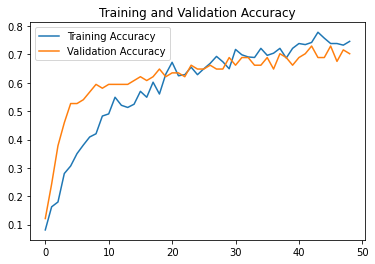

<Figure size 432x288 with 0 Axes>

c:\users\hp\pycharmprojects\pythonproject5\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
c:\users\hp\pycharmprojects\pythonproject5\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


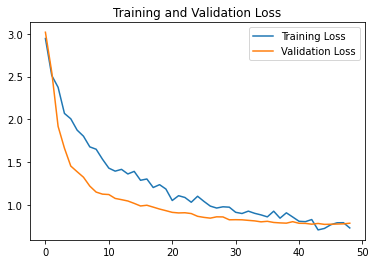

<Figure size 432x288 with 0 Axes>

In [18]:
do_history_stuff(inceptionv3_history, 'inceptionv3_model', False)  

In [74]:
cudaDeviceReset()

NameError: name 'cudaDeviceReset' is not defined

In [10]:
vgg_best_model = keras.models.load_model('C:\\Users\hp\\PycharmProjects\\pythonProject5\\vgg_16_-saved-model-70-acc-0.78.hdf5')
resnet_best_model=keras.models.load_model("resnet50-saved-model-10-val_acc-0.16.hdf5")
inception_best_model=keras.models.load_model("inceptionv3_-saved-model-44-loss-0.71.hdf5")
model=keras.models.load_model("bench_mark_-model-14-0.38.hdf5")


In [33]:
import os 
import cv2
def mode(my_list):
    ct = Counter(my_list)
    max_value = max(ct.values())
    return ([key for key, value in ct.items() if value == max_value])

true_value = []
combined_model_pred = []
vgg_pred = []
resnet_pred = []
inception_pred = []
benchmark_model_pred = []
path2='data\\vechicle_with_train\\vechicles\\valad'
for folder in os.listdir(path2):
    
    test_image_ids = os.listdir(os.path.join(path2,folder))

    for image_id in test_image_ids[:int(len(test_image_ids))]:
        
        path = os.path.join(path2,folder,image_id)
        
        true_value.append(val_generator.class_indices[folder])
        img = cv2.resize(cv2.imread(path),(150,150))
        img_normalized = img/255
        #vgg
        vgg16_image_prediction = np.argmax(vgg_best_model.predict(np.array([img_normalized])))
        vgg_pred.append(vgg16_image_prediction)
        
        #resnet50
        resnet_50_image_prediction = np.argmax(resnet_best_model.predict(np.array([img_normalized])))
        resnet_pred.append(resnet_50_image_prediction)
        
        #Inception
        inception_image_prediction = np.argmax(inception_best_model.predict(np.array([img_normalized])))
        inception_pred.append(inception_image_prediction)
        
        #benchmark
        benchmark_model_prediction = np.argmax(model.predict(np.array([img_normalized])))
        benchmark_model_pred.append(benchmark_model_prediction)
        print(benchmark_model_prediction)
        print(val_generator.class_indices[folder])
        
        #giving vgg16 high priority if they all predict something different
        #image_prediction = mode([vgg16_image_prediction, resnet_50_image_prediction, inception_image_prediction])                                  
        #combined_model_pred.append(image_prediction)

1/1 [==============================] - 0s 33ms/step
3
0
1/1 [==============================] - 0s 37ms/step
0
0
1/1 [==============================] - 0s 32ms/step
0
0
1/1 [==============================] - 0s 46ms/step
0
0
1/1 [==============================] - 0s 35ms/step
0
0
1/1 [==============================] - 0s 30ms/step
0
0
1/1 [==============================] - 0s 37ms/step
0
0
1/1 [==============================] - 0s 32ms/step
0
0
1/1 [==============================] - 0s 60ms/step
0
0
1/1 [==============================] - 0s 30ms/step
0
0
1/1 [==============================] - 0s 31ms/step
1
1
1/1 [==============================] - 0s 33ms/step
8
1
1/1 [==============================] - 0s 33ms/step
8
1
1/1 [==============================] - 0s 37ms/step
6
1
1/1 [==============================] - 0s 36ms/step
8
1
1/1 [==============================] - 0s 30ms/step
3
1
1/1 [==============================] - 0s 30ms/step
1
1
1/1 [==============================] - 0s 30ms/s

1/1 [==============================] - 0s 36ms/step
0
7
1/1 [==============================] - 0s 34ms/step
3
7
1/1 [==============================] - 0s 34ms/step
3
7
1/1 [==============================] - 0s 35ms/step
2
7
1/1 [==============================] - 0s 59ms/step
2
8
1/1 [==============================] - 0s 39ms/step
3
8
1/1 [==============================] - 0s 34ms/step
0
8
1/1 [==============================] - 0s 46ms/step
2
8
1/1 [==============================] - 0s 37ms/step
0
8
1/1 [==============================] - 0s 34ms/step
2
8
1/1 [==============================] - 0s 31ms/step
3
8
1/1 [==============================] - 0s 44ms/step
2
8
1/1 [==============================] - 0s 36ms/step
0
8
1/1 [==============================] - 0s 34ms/step
8
8
1/1 [==============================] - 0s 42ms/step
3
9
1/1 [==============================] - 0s 52ms/step
8
9
1/1 [==============================] - 0s 41ms/step
0
9
1/1 [==============================] - 0s 34ms/s

Model Accuracy 0.81
              precision    recall  f1-score   support

        bike       0.80      0.80      0.80        10
        boat       1.00      0.90      0.95        10
         bus       0.83      0.45      0.59        11
         car       1.00      0.80      0.89        10
       cycle       0.83      1.00      0.91        10
  helicopter       0.75      0.90      0.82        10
       plane       1.00      0.80      0.89        10
      scooty       1.00      0.80      0.89        10
       train       0.67      1.00      0.80        10
       truck       0.50      0.67      0.57         9

    accuracy                           0.81       100
   macro avg       0.84      0.81      0.81       100
weighted avg       0.84      0.81      0.81       100



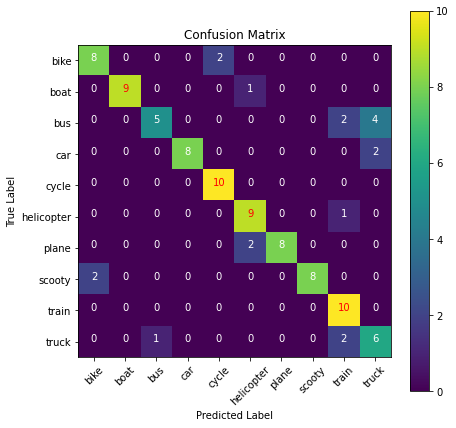

In [34]:
clf_report(true_value, vgg_pred
          )

Model Accuracy 0.09
              precision    recall  f1-score   support

        bike       0.00      0.00      0.00        10
        boat       0.00      0.00      0.00        10
         bus       0.00      0.00      0.00        11
         car       0.00      0.00      0.00        10
       cycle       0.00      0.00      0.00        10
  helicopter       0.03      0.10      0.05        10
       plane       0.11      0.80      0.20        10
      scooty       0.00      0.00      0.00        10
       train       0.00      0.00      0.00        10
       truck       0.00      0.00      0.00         9

    accuracy                           0.09       100
   macro avg       0.01      0.09      0.03       100
weighted avg       0.01      0.09      0.03       100



c:\users\hp\pycharmprojects\pythonproject5\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\hp\pycharmprojects\pythonproject5\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\hp\pycharmprojects\pythonproject5\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


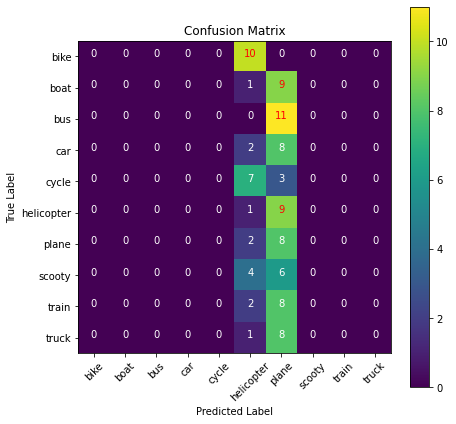

In [35]:
clf_report(true_value,  resnet_pred
          )


Model Accuracy 0.88
              precision    recall  f1-score   support

        bike       0.89      0.80      0.84        10
        boat       0.77      1.00      0.87        10
         bus       1.00      0.73      0.84        11
         car       0.77      1.00      0.87        10
       cycle       1.00      1.00      1.00        10
  helicopter       1.00      0.90      0.95        10
       plane       0.91      1.00      0.95        10
      scooty       0.82      0.90      0.86        10
       train       0.80      0.80      0.80        10
       truck       1.00      0.67      0.80         9

    accuracy                           0.88       100
   macro avg       0.90      0.88      0.88       100
weighted avg       0.90      0.88      0.88       100



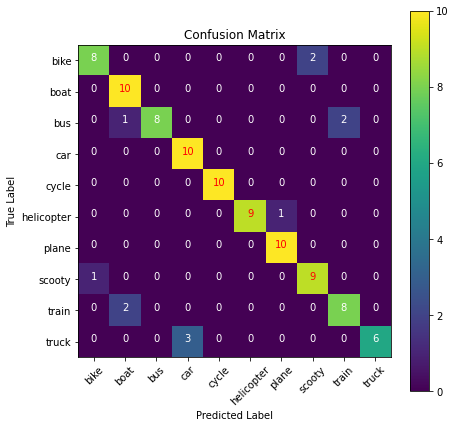

In [36]:
clf_report(true_value,  inception_pred
          )

Model Accuracy 0.28
              precision    recall  f1-score   support

        bike       0.41      0.90      0.56        10
        boat       0.50      0.20      0.29        10
         bus       0.18      0.18      0.18        11
         car       0.16      0.40      0.23        10
       cycle       0.75      0.60      0.67        10
  helicopter       0.00      0.00      0.00        10
       plane       0.67      0.40      0.50        10
      scooty       0.00      0.00      0.00        10
       train       0.05      0.10      0.07        10
       truck       0.00      0.00      0.00         9

    accuracy                           0.28       100
   macro avg       0.27      0.28      0.25       100
weighted avg       0.27      0.28      0.25       100



c:\users\hp\pycharmprojects\pythonproject5\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\hp\pycharmprojects\pythonproject5\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\hp\pycharmprojects\pythonproject5\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


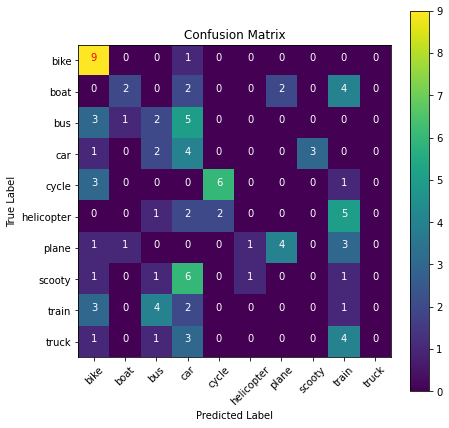

In [37]:
clf_report(true_value,  benchmark_model_pred
          )

Summary: 
The quality of both the resnet and the benchmark model were bad because the data set was not enough and resulted in the benchmark model to not extract enough features and the resnet model to over fit to the training data  . 
Both the vgg and the inception models had a decent performance with high metrics overall and can both be used for this classification it was decided to use the vgg model since it is more has less weights over all and will result in faster prediction with acceptable performance   
Summary of Key Findings     :  
It was found that without further increasing the data or increasing the number of training epochs both the resnet and the normal covnet will not be able to perform better 
It can be noticed from the confusion matrix that both the vgg16 and the inception model have a hard time in classifying the trucks class it can mistake with similar looking vehicles . 
By using a pertained network head previously trained on a huge dataset the model training time and accuracy can be efficiently improved without a huge investment in resources if the task is generic enough    
 Future work: 
More training data can be fetched to make it so that the model is exposed to a more diverse data set and also improve the resnet model prediction  more per trained models can be tried to find a better suiting model for this classification  
more training epochs can be added to the models in case that further training might increase the model performance   
 
